In [2]:
import os, sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
bigdama_path = "/home/andres/CAiN_repos/OutlierDenStream-BigDama18/"
sys.path.append(bigdama_path)

from readGroundTruth import groundTruth

In [6]:
def normalize_matrix(df):
    return (df - df.mean())/df.std()

configuration = json.load(open('configuration.json'))
print(configuration['featureModel'])

# Iterate on all the datasets chosen in the configuration list
for dataset in configuration['dataset']['list']:
    
    telemetry_allLeafs = pd.DataFrame()
    
    # read the ground truth file
    truth = groundTruth(bigdama_path + 'GrounTruth/'+dataset+'.txt', fileType='csv')
    
    # Iterate on all the nodes chosen in the configuration file
    for node in configuration['nodes']:

        # Read node dataset
        print('Dataset {} - Node: {} loading ...'.format(dataset,node))
        df = pd.read_csv(bigdama_path+configuration['dataset']['path']+node+dataset+'.csv', low_memory = False)\
                        .dropna()\
                        .drop('Unnamed: 0', axis=1)
        print('Done.')
        
        times = pd.DataFrame(columns=['time'])
        times['time'] = df['time'].astype('int')
        df = df.drop(['time'], axis=1)

        # Select the chosen features in the configuration file
        # By default the dataset contains all the features
        # If ControlPlane is chosen: only the CP features are extracted from the dataset
        # If DataPlane is chosen: the CP features are discarded, obtaining a dataset with only DataPlane
        # If CompleteFeatures is chosen: pass
        if configuration['featureModel'] == 'ControlPlane':
            features = 'CP'
            df = df[configuration['featureList']]
        elif configuration['featureModel'] == 'DataPlane':
            features = 'DP'
            df = df.drop(configuration['featureList'], axis=1)
        elif configuration['featureModel'] == 'CompleteFeatures':
            features = 'All'
        else:
            sys.exit('Something wrong in configuration feature model')

        # Dataset normalization
        df_short = df.loc[:,df.std()!=0]
        dfNormalized = normalize_matrix(df_short).dropna(axis=1)
        del df_short
        
        # Add leaf to allLeafs dataset
        telemetry_allLeafs = pd.concat([telemetry_allLeafs, dfNormalized], axis=1, ignore_index=True).dropna()
        
        print(f"Entries in {node}: {len(times)}")
        
        dfNormalized[0:].to_csv(dataset+'_'+node+'_'+features+'.emb', index=False, header=False, na_rep=0, sep='\t')
        #df[0:].to_csv(dataset+'_'+node+'_'+features+'.emb', index=False, header=False, na_rep=0, sep='\t')
        
        # Create anomaly data
        times['anomaly'] = 0 # add new column
        times['node'] = node

        # flag entries within anomaly ranges
        for anomaly in truth.events:
            mask = times['time'].between(anomaly['startTime'], anomaly['endTime'])
            times['anomaly'] = times['anomaly'].mask(mask, 1)

        times[0:].to_csv(dataset+'_'+node+'_'+features+'.lbl', index=False, header=True, na_rep=0, sep='\t')
        
# Print allLeafs data
telemetry_allLeafs[0:].to_csv(dataset+'_'+features+'.emb', index=False, header=False, na_rep=0, sep='\t')
        
dfNormalized.head()
telemetry_allLeafs.head()

DataPlane
Dataset portflap_first - Node: leaf1 loading ...
Done.
Entries in leaf1: 350
Dataset portflap_first - Node: leaf2 loading ...
Done.
Entries in leaf2: 350
Dataset portflap_first - Node: leaf3 loading ...
Done.
Entries in leaf3: 349
Dataset portflap_first - Node: leaf5 loading ...
Done.
Entries in leaf5: 348
Dataset portflap_first - Node: leaf6 loading ...
Done.
Entries in leaf6: 348
Dataset portflap_first - Node: leaf7 loading ...
Done.
Entries in leaf7: 350
Dataset portflap_first - Node: leaf8 loading ...
Done.
Entries in leaf8: 349
Dataset portflap_first - Node: spine1 loading ...
Done.
Entries in spine1: 348
Dataset portflap_first - Node: spine2 loading ...
Done.
Entries in spine2: 347
Dataset portflap_first - Node: spine3 loading ...
Done.
Entries in spine3: 347
Dataset portflap_first - Node: spine4 loading ...
Done.
Entries in spine4: 348


,0,1,2,3,4,5,6,7,8,9,...,2131,2132,2133,2134,2135,2136,2137,2138,2139,2140
0,-0.303755,0.188153,-0.510220,-0.731936,-0.731065,-0.125302,0.632798,0.625162,0.736235,-1.237922,...,-1.719055,-1.721527,-1.541184,-1.712355,-1.640645,-1.713287,-1.492342,-1.707401,-1.575430,-1.703380
1,-0.238127,0.188153,-0.668176,-0.768800,-0.731065,-0.524728,0.613976,0.625162,0.694066,-0.949254,...,-1.709215,-1.711444,-1.535746,-1.702209,-1.632999,-1.702994,-1.488956,-1.698994,-1.569958,-1.694733
2,-0.042368,0.188153,-0.686747,-0.804364,-0.731065,-0.736473,0.586040,0.625162,0.670500,-0.954050,...,-1.698725,-1.700138,-1.529411,-1.692802,-1.624211,-1.693438,-1.485193,-1.689470,-1.563984,-1.685386
3,-0.094842,0.188153,-0.682760,-0.859906,-0.912664,-1.427014,0.543730,0.541966,0.562391,-0.337407,...,-1.689257,-1.690001,-1.523606,-1.684179,-1.615826,-1.684768,-1.481801,-1.680896,-1.558502,-1.676886
4,-0.113459,0.188153,-0.532728,-0.803910,-0.731065,-1.161881,0.519885,0.541966,0.584797,-0.203088,...,-1.679864,-1.680819,-1.518413,-1.675872,-1.608269,-1.676493,-1.478575,-1.672014,-1.553146,-1.668227


/home/andres/src/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  


ConversionError: Failed to convert value(s) to axis units: array(['leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1',
       'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1', 'leaf1'],
      dtype=object)

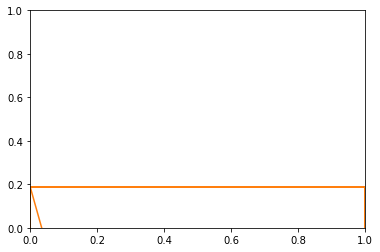

In [8]:
fig, ax = plt.subplots()
#ax.plot(times, dfNormalized['active-routes-count'], 'b')
#ax.plot(times, dfNormalized['deleted-routes-count'], 'g')
#ax.plot(times, dfNormalized['paths-count'], 'r')
#ax.plot(times, dfNormalized['protocol-route-memory'], 'y')
ax.plot(times, dfNormalized)
#ax.axis([0, 700, 900, 1500])
ax.set_ylim([-3, 3])
for anomaly in truth.events:
    ax.axvspan(anomaly['startTime'], anomaly['endTime'], alpha=0.2, color='red')

In [26]:
help(pd.concat)

Help on function concat in module pandas.core.reshape.concat:

concat(objs, axis=0, join='outer', join_axes=None, ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False, sort=None, copy=True)
    Concatenate pandas objects along a particular axis with optional set logic
    along the other axes.
    
    Can also add a layer of hierarchical indexing on the concatenation axis,
    which may be useful if the labels are the same (or overlapping) on
    the passed axis number.
    
    Parameters
    ----------
    objs : a sequence or mapping of Series or DataFrame objects
        If a dict is passed, the sorted keys will be used as the `keys`
        argument, unless it is passed, in which case the values will be
        selected (see below). Any None objects will be dropped silently unless
        they are all None in which case a ValueError will be raised.
    axis : {0/'index', 1/'columns'}, default 0
        The axis to concatenate along.
    join : {'inner', 

In [33]:
df4 = pd.DataFrame([['bird', 'polly'], ['monkey', 'george'], ['turtle', 'molly']],columns=['animal', 'name'])

In [34]:
df1 = pd.DataFrame([['a', 1, "perro"], ['b', 2, 'gato']],columns=['letter', 'number', "animal"])

In [38]:
pd.concat([df1, df4], axis=1, ignore_index=True).dropna()

,0,1,2,3,4
0,a,1.0,perro,bird,polly
1,b,2.0,gato,monkey,george
